In [154]:
import pandas as pd
import numpy as np 
import os
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from keras.losses import binary_crossentropy, mse
import random
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

In [2]:
work_path = os.open('...',os.O_RDONLY)
files = os.listdir(work_path)
files= sorted(files)
files = files[1:]
end_bid = files.index('...')
files = files[:end_bid]

In [3]:
vu_vec = []
time_step = 0
for file in files:
    vu_vec.append(np.load('...' + file).item())
    time_step += 1

In [4]:
df_order = pd.read_csv('...', sep = '\t', compression='gzip')

In [5]:
df_deal_vec = pd.read_csv('...', compression='gzip')
df_deal_vec.dealvec = df_deal_vec.dealvec.map(lambda x: x[2:-2].split())

In [6]:
df_order['ins_tm'] = pd.to_datetime(df_order['ins_tm'],format='%Y-%m-%d %H:%M:%S')
df_order['date'] = df_order.ins_tm.dt.date
train_order = df_order.loc[df_order.date <= datetime.date(2017,6,18)]
train_order = train_order.loc[df_order.date >= datetime.date(2017,6,12)]
train_order = train_order[['account_id','deal_id']]
train_order['rating'] = 1

In [167]:
dev_order = df_order.loc[df_order.date == datetime.date(2017,6,19)]
dev_order = test_order[['account_id','deal_id']]
dev_order['rating'] = 1

In [168]:
test_order = df_order.loc[df_order.date == datetime.date(2017,6,20)]
test_order = test_order[['account_id','deal_id']]
test_order['rating'] = 1

In [7]:
item_list = list(train_order.deal_id.unique())
user_list = list(train_order.account_id.unique())

num_epo = 0
Negative_sample = []
for user in user_list:
    bought_list = list(train_order[train_order.account_id == user].deal_id.values)
    negative_list = list(set(item_list)^set(bought_list))
    some = random.sample(negative_list, len(bought_list))
    for i in range(len(bought_list)):
        Negative_sample.append([user, some[i], 0])
    if num_epo%10000 == 0:
        print(str(num_epo) + '/' + str(len(user_list)) + 'finished!')
    num_epo += 1
df_Ns = pd.DataFrame(Negative_sample, columns=['account_id', 'deal_id', 'rating'])
train_order = train_order.append(df_Ns, ignore_index=True)

0/39322finished!
10000/39322finished!
20000/39322finished!
30000/39322finished!


In [171]:
item_list = list(dev_order.deal_id.unique())
user_list = list(dev_order.account_id.unique())

num_epo = 0
Negative_sample = []
for user in user_list:
    bought_list = list(dev_order[dev_order.account_id == user].deal_id.values)
    negative_list = list(set(item_list)-set(bought_list))
    some = random.sample(negative_list, len(set(bought_list)&set(item_list)))
    for i in range(len(set(bought_list)&set(item_list))):
        Negative_sample.append([user, some[i], 0])
    if num_epo%10000 == 0:
        print(str(num_epo) + '/' + str(len(user_list)) + 'finished!')
    num_epo += 1
df_Ns = pd.DataFrame(Negative_sample, columns=['account_id', 'deal_id', 'rating'])
dev_order = dev_order.append(df_Ns, ignore_index=True)

0/5317finished!


In [172]:
item_list = list(test_order.deal_id.unique())
user_list = list(test_order.account_id.unique())

num_epo = 0
Negative_sample = []
for user in user_list:
    bought_list = list(test_order[test_order.account_id == user].deal_id.values)
    negative_list = list(set(item_list)-set(bought_list))
    some = random.sample(negative_list, len(set(bought_list)&set(item_list)))
    for i in range(len(set(bought_list)&set(item_list))):
        Negative_sample.append([user, some[i], 0])
    if num_epo%10000 == 0:
        print(str(num_epo) + '/' + str(len(user_list)) + 'finished!')
    num_epo += 1
df_Ns = pd.DataFrame(Negative_sample, columns=['account_id', 'deal_id', 'rating'])
test_order = test_order.append(df_Ns, ignore_index=True)

0/4412finished!


In [8]:
from sklearn.model_selection import train_test_split
train, dev = train_test_split(train_order, test_size = 0.05)

In [39]:
def changeID2vec(i,user_id):
    num_empty = 0
    try:
        user_vec = vu_vec[i][user_id]
    except:
        #user_vec = np.zeros([1,200], dtype = float)
        user_vec = []
        num_empty = 1
    return user_vec, num_empty

In [40]:
def preprocess(df, valid_day):
    # generate input feature of user_vec and item_vec
    user_list = [] # train.account_id.values
    item_list = [] # train.deal_id.values
    label = df.rating.values
    num_empty = []

    for user_id in df.account_id.values:
        temp_vec = []
        emp_num = 0
        for i in range(time_step):
            user_vec, emt = changeID2vec(i,user_id)
            temp_vec.extend(user_vec)
            emp_num += emt
        for i in range(emp_num):
            temp_vec.extend(np.zeros([1,200], dtype = float))
        user_list.append(temp_vec)
        num_empty.append(emp_num)

    for item_id in df.deal_id.values:
        item_list.extend(df_deal_vec.loc[df_deal_vec.deal_id == item_id]['dealvec'].values) 

    useful_index = []
    for i in range(len(num_empty)):
        if(num_empty[i] <= time_step-valid_day):
            useful_index.extend([i])

    useful_user_list = []
    useful_item_list = []
    useful_label_list = []
    for index in useful_index:
        useful_user_list.append(user_list[index])
        useful_item_list.append(item_list[index])
        useful_label_list.append(label[index])

    useful_user = np.array(useful_user_list)
    useful_item = np.array(useful_item_list)
    useful_label = np.array(useful_label_list)
    
    return useful_user, useful_item, useful_label

In [59]:
train_user, train_item, train_label = preprocess(train,5)

In [173]:
train_dev_user, train_dev_item, train_dev_label = preprocess(dev,5)

In [174]:
dev_user, dev_item, dev_label = preprocess(dev_order, 5)

In [140]:
test_user, test_item, test_label = preprocess(test_order, 5)

# bi-LSTM with attention

In [182]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [183]:
#Defined shared layers
concatenator = Concatenate(axis=-1)
densor1 = Dense(12, activation='tanh')
densor2 = Dense(1, activation='relu')
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes=1)

Norm_user = BatchNormalization()
Norm_item = BatchNormalization()

densor_user1 = Dense(128, activation='relu')
densor_deal1 = Dense(128, activation='relu')
densor_user2 = Dense(128, activation='relu')
densor_deal2 = Dense(128, activation='relu')
densor_user3 = Dense(64, activation='relu')
densor_deal3 = Dense(64, activation='relu')
densor_user4 = Dense(32, activation='relu')
densor_deal4 = Dense(32, activation='relu')

flat = Flatten()
concat = Dot(axes=1)
output = Dense(1, activation='sigmoid')

In [184]:
def one_step_attention(a):
    e = densor1(a)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    return context

In [185]:
def model_generate(Tx, n_a, vec_dim):
    X_user = Input(shape=(Tx, vec_dim))
    
    a = Bidirectional(LSTM(n_a, return_sequences= True))(X_user)
    context = one_step_attention(a)
    
    X_deal = Input(shape=(vec_dim,))
     
    flat_user = flat(context)
    
    user_0 = Norm_user(flat_user)
    deal_0 = Norm_item(X_deal)
    user_1 = densor_user1(user_0)
    deal_1 = densor_deal1(deal_0)
    user_2 = densor_user2(user_1)
    deal_2 = densor_deal2(deal_1)
    user_3 = densor_user3(user_2)
    deal_3 = densor_deal3(deal_2)
    user_4 = densor_user4(user_3)
    deal_4 = densor_deal4(deal_3)
    
    hidden = concat([user_4, deal_4])
    pred = output(hidden)
    
    model = Model(input = [X_user, X_deal], outputs = pred)
    return model

In [186]:
model = model_generate(time_step, 256, 200)

/home/mmde-lab/anaconda3/envs/whxPyEnv/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [187]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 32, 200)      0                                            
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 32, 512)      935936      input_32[0][0]                   
__________________________________________________________________________________________________
dense_155 (Dense)               (None, 32, 12)       6156        bidirectional_16[0][0]           
__________________________________________________________________________________________________
dense_156 (Dense)               (None, 32, 1)        13          dense_155[0][0]                  
__________________________________________________________________________________________________
attention_

In [188]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

check_point = ModelCheckpoint('model.hdf5', verbose=True, save_best_only = True)
early_stop = EarlyStopping(patience=3, verbose=True)

opt = model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001),
                   metrics = ['accuracy'],
                   loss = binary_crossentropy)
history = model.fit([train_user, train_item], train_label,
          validation_data= ([train_dev_user, train_dev_item], train_dev_label),
          epochs=100,
          batch_size=32,
          verbose=True,
          callbacks=[early_stop, check_point])

Train on 21010 samples, validate on 1108 samples
Epoch 1/100
21010/21010 [==============================] - 35s 2ms/step - loss: 0.6037 - acc: 0.7188 - val_loss: 0.5277 - val_acc: 0.7933

Epoch 00001: val_loss improved from inf to 0.52766, saving model to model.hdf5
Epoch 2/100
21010/21010 [==============================] - 28s 1ms/step - loss: 0.5280 - acc: 0.7762 - val_loss: 0.5001 - val_acc: 0.8069

Epoch 00002: val_loss improved from 0.52766 to 0.50008, saving model to model.hdf5
Epoch 3/100
21010/21010 [==============================] - 28s 1ms/step - loss: 0.4958 - acc: 0.7909 - val_loss: 0.4685 - val_acc: 0.8150

Epoch 00003: val_loss improved from 0.50008 to 0.46849, saving model to model.hdf5
Epoch 4/100
21010/21010 [==============================] - 28s 1ms/step - loss: 0.4645 - acc: 0.8066 - val_loss: 0.4446 - val_acc: 0.8186

Epoch 00004: val_loss improved from 0.46849 to 0.44456, saving model to model.hdf5
Epoch 5/100
21010/21010 [==============================] - 28s 1ms/

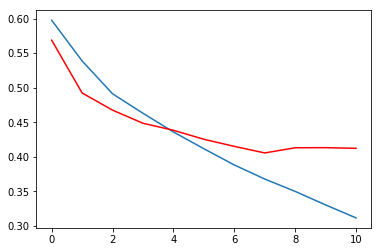

In [164]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='r')

In [165]:
def model_pred(df_user, df_item):
    pred_result = model.predict([df_user, df_item])
    return pred_result
def new_print_result(df_user, df_item, df_label):
    pred_result = model_pred(df_user, df_item)
    for i in range(len(pred_result)):
        pred_result[i] = int(pred_result[i][0] >= 0.5)
    print((pred_result == 1).sum())
    print('accuracy: ',  accuracy_score(df_label, pred_result))
    print(classification_report(df_label, pred_result))

In [191]:
new_print_result(train_dev_user, train_dev_item, train_dev_label)

578
accuracy:  0.8240072202166066
             precision    recall  f1-score   support

          0       0.85      0.80      0.82       561
          1       0.80      0.85      0.83       547

avg / total       0.83      0.82      0.82      1108



In [189]:
new_print_result(test_user, test_item, test_label)

1589
accuracy:  0.6862680683311432
             precision    recall  f1-score   support

          0       0.69      0.67      0.68      1510
          1       0.68      0.71      0.69      1534

avg / total       0.69      0.69      0.69      3044



In [192]:
len(train_dev_item)

1108

In [194]:
len(train_item)

21010